# Lego Parts in Sets - Graph

Requirements to run as-is:
* Google Colab and Google Drive
* Drive folder `/lego`
* Folder `/lego` contains Rebrickable [downloads](https://rebrickable.com/downloads/)
* Folder `/lego` contains a Rebrickable [API](https://rebrickable.com/api/v3/docs/) Key in the file `rbl`



# Get Data

## Google Drive

In [1]:
UPLOAD_FOLDER = 'My Drive/lego/'
CACHE_FOLDER = 'cache/'

GDRIVE_ROOT = '/content/gdrive/'
FS_ROOT = GDRIVE_ROOT + UPLOAD_FOLDER
RAW_ROOT = FS_ROOT
CACHE_DIR = RAW_ROOT + CACHE_FOLDER

from google.colab import drive
drive.mount(GDRIVE_ROOT)

Mounted at /content/gdrive/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def get_df(fname):
  return pd.read_csv(RAW_ROOT + fname)

# Rebrickable downloads
parts_df = get_df('parts.csv').set_index('part_num')
sets_df = get_df('sets.csv').set_index('set_num')
inventories_df = get_df('inventories.csv').set_index('id')
inventory_parts_df = get_df('inventory_parts.csv')
colors_df = get_df('colors.csv').set_index('id')
minifigs_df = get_df('minifigs.csv').set_index('fig_num')

## Rebrickable API & Drive Cache

In [3]:
import requests

RBL_HOST = 'https://rebrickable.com'
RBL_ROOT = '/api/v3/lego/'
RBL_PRE = RBL_HOST + RBL_ROOT

key_file = open(RAW_ROOT + 'rbl', 'r')
rbl_api_key = key_file.readlines()[0].strip()
auth_value = 'key ' + rbl_api_key
RBL_HDR = {'Authorization': auth_value }

def get_rbl_uri(uri):
  return requests.get(uri, headers=RBL_HDR).json()

def get_part_details(part_num):
  return requests.get(RBL_PRE + f'parts/{part_num}', headers=RBL_HDR).json()

def get_part_list_details(part_nums):
  part_nums_param_val = ','.join([str(p) for p in part_nums])
  other_params = '&inc_part_details=1&page_size=1000'
  uri = RBL_PRE + f'parts/?part_nums={part_nums_param_val}' + other_params
  return requests.get(uri, headers=RBL_HDR).json()

In [4]:
import glob
import json
import time

def write_part_results(results, page_num):
  Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)
  results_file_name = CACHE_DIR + f'results_page_{page_num:03d}.json'
  with open(results_file_name, 'w') as outfile:
    json.dump(results, outfile)

def cache_all_parts(max_pages=100):
  page_index = 0
  page_response = get_part_list_details([])
  while page_response['next'] is not None and page_index < max_pages:
    print(f'caching results page {page_index}')
    write_part_results(page_response['results'], page_index)
    page_index = page_index + 1
    # be nice to Rebrickable API
    time.sleep(10)
    page_response = get_rbl_uri(page_response['next'])

cache_exists = len(glob.glob(CACHE_DIR + '*.json')) > 0
if not cache_exists:
  cache_all_parts()
else:
  print('cache exists')

cache exists


In [5]:
def build_cache_index():
  dir_list = sorted(glob.glob(CACHE_DIR + '*.json'))
  json_cache = []
  for f in dir_list:
    with open(f) as json_file:
      data = json.load(json_file)
      json_cache = json_cache + data
  return {p['part_num'] : p for p in json_cache}

# Set Up Data Structures

In [6]:
sets_parts_df = pd.merge(inventory_parts_df,
                         inventories_df,
                         how='left',
                         left_on='inventory_id',
                         right_index=True)[['set_num',
                                            'part_num',
                                            'quantity',
                                            'color_id',
                                            'is_spare']]
sets_parts_df.head()

,set_num,part_num,quantity,color_id,is_spare
0,7922-1,48379c01,1,72,f
1,7922-1,48395,1,7,f
2,7922-1,stickerupn0077,1,9999,f
3,7922-1,upn0342,1,0,f
4,7922-1,upn0350,1,25,f


In [7]:
spq_all = sets_parts_df.groupby(['set_num', 'part_num']).sum()['quantity']
spq_all.head()

set_num  part_num
001-1    132a        4
         3020        4
         3062c       1
         3404bc01    4
         36          4
Name: quantity, dtype: int64

In [8]:
sp_inc_sort = spq_all.groupby(['set_num']).count().sort_values(ascending=False)

psq = sets_parts_df.groupby(['part_num', 'set_num']).sum()['quantity']
ps_inc_sort = psq.groupby(['part_num']).count().sort_values(ascending=False)
ps_inc_sort.head()

part_num
3023      6270
6141      5429
3020      5417
3022      5376
970c00    5025
Name: quantity, dtype: int64

# Represent as Bipartite Graph

In [9]:
from collections.abc import Iterable

# thanks Christian from StackOverflow
def flatten(l):
  for el in l:
    if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
      yield from flatten(el)
    else:
      yield el

In [10]:
spq_sets = list(sp_inc_sort.index)
spq_parts = list(ps_inc_sort.index)
sp_part_lists = [list(spq_all.loc[s].index) for s in spq_sets]
sp_sets_rpt = [[spq_sets[i]] * len(l) for i, l in enumerate(sp_part_lists)]
edges = list(zip(flatten(sp_sets_rpt), flatten(sp_part_lists)))

In [11]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()
B.add_nodes_from(spq_sets, bipartite=0)
B.add_nodes_from(spq_parts, bipartite=1)
B.add_edges_from(edges)
B_conn = nx.is_connected(B)
B_dens = bipartite.density(B, spq_sets)
print(f'Bipartite set-part graph, {len(B)} nodes ({len(spq_sets)} sets + {len(spq_parts)} parts)')
print(f'Joined with {len(B.edges())} edges, density {B_dens:0.5f}, fully connected {B_conn}')

Bipartite set-part graph, 63252 nodes (25310 sets + 37942 parts)
Joined with 633440 edges, density 0.00066, fully connected False


# Visualise Graph

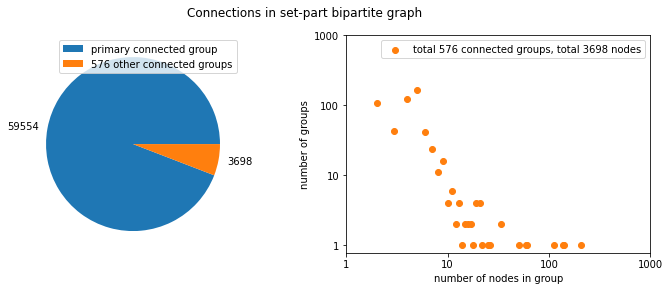

In [12]:
conn_comp = list(nx.connected_components(B))
cc_lens = [len(cc) for cc in conn_comp]
primary_rest_cc_lens = [cc_lens[0], sum(cc_lens[1:])]

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

ax[0].pie(primary_rest_cc_lens, labels=primary_rest_cc_lens)
ax[0].legend(['primary connected group', f'{len(cc_lens) - 1} other connected groups'])

cc_lens_distn = np.unique(cc_lens, return_counts=True)
ax[1].scatter(np.log10(cc_lens_distn[0][:-1]),
              np.log10(cc_lens_distn[1][:-1]),
              color='tab:orange')
ax[1].set_xticks(np.arange(0, 4))
ax[1].set_xticklabels(np.power(10, np.arange(0, 4)))
ax[1].set_yticks(np.arange(0, 4))
ax[1].set_yticklabels(np.power(10, np.arange(0, 4)))
ax[1].set_xlabel('number of nodes in group')
ax[1].set_ylabel('number of groups')

ax[1].legend([f'total {len(cc_lens) - 1} connected groups, total {sum(cc_lens[1:])} nodes'])

fig.suptitle('Connections in set-part bipartite graph')
plt.show()

In [13]:
flipper_id = '10190'

jcpn = build_cache_index()

In [14]:
def selected_nbrs(node, step=30):
  return list(B.neighbors(node))[::step]

sel_nbrs = selected_nbrs(flipper_id)
sel_nbrs_nbrs = list(set(flatten([selected_nbrs(n) for n in sel_nbrs])))
sel_nodes = [flipper_id] + sel_nbrs + sel_nbrs_nbrs
len(sel_nbrs), len(sel_nbrs_nbrs)

(3, 14)

In [15]:
all_nbrs = selected_nbrs(flipper_id, step=1)
all_nbrs_nbrs = list(set(flatten([selected_nbrs(n, step=1) for n in all_nbrs])))
all_flipper_nodes = [flipper_id] + all_nbrs + all_nbrs_nbrs
len(all_nbrs), len(all_nbrs_nbrs)

(79, 1313)

In [16]:
from PIL import Image

def transparent_part_image(part_num, content_alpha=255):
  img = Image.new("RGBA",(10, 10), (0,0,0,0))
  url = jcpn[part_num]['part_img_url']
  if url is not None:
    img_in = Image.open(requests.get(url, stream=True).raw)
    x = np.asarray(img_in.convert('RGBA')).copy()
    x[:, :, 3] = (content_alpha * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    img = Image.fromarray(x)
  return img

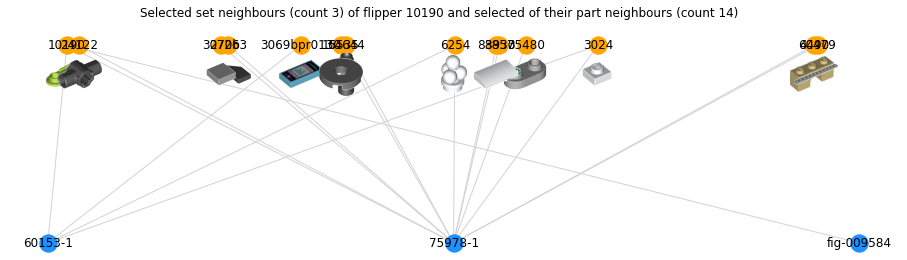

In [17]:
Sb = B.subgraph(sel_nodes)

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(4)
ax.axis('off')

posb = nx.bipartite_layout(Sb, spq_parts, align='horizontal')
nx.draw_networkx_edges(Sb, pos=posb, edgelist=Sb.edges, edge_color='lightgrey')
nx.draw_networkx_nodes(Sb, pos=posb, nodelist=sel_nbrs_nbrs, node_color='orange')
nx.draw_networkx_nodes(Sb, pos=posb, nodelist=sel_nbrs, node_color='dodgerblue')
nx.draw_networkx_labels(Sb, pos=posb, labels={n:n for n in Sb.nodes})
inset_d = 0.15
for snn in sel_nbrs_nbrs:
  inset_x = (posb[snn][0] + 0.83) / 1.9
  inset_y = posb[snn][1] + 0.67
  inset = fig.add_axes([inset_x, inset_y, inset_d, inset_d])
  inset.imshow(transparent_part_image(snn))
  inset.axis('off')

fig.patch.set_visible(False)
fig.suptitle(f'Selected set neighbours (count {len(sel_nbrs)}) of flipper {flipper_id} and selected of their part neighbours (count {len(sel_nbrs_nbrs)})')
plt.show()

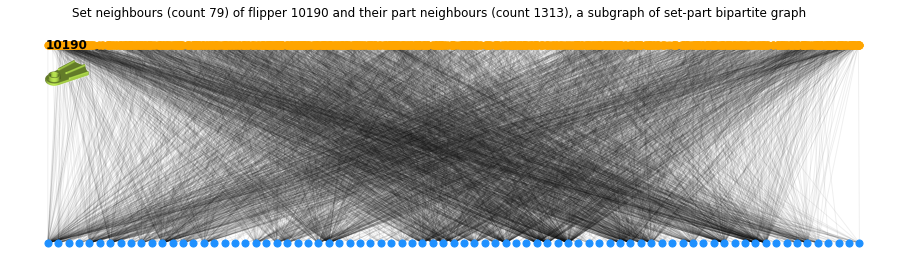

In [18]:
Sb = B.subgraph(all_flipper_nodes)

fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(4)
ax.axis('off')

posb = nx.bipartite_layout(Sb, spq_parts, align='horizontal')
nx.draw_networkx_edges(Sb, pos=posb, edgelist=Sb.edges, edge_color='#00000010')
nx.draw_networkx_nodes(Sb, pos=posb, nodelist=all_nbrs_nbrs, node_color='orange', node_size=50)
nx.draw_networkx_nodes(Sb, pos=posb, nodelist=all_nbrs, node_color='dodgerblue', node_size=50)
nx.draw_networkx_labels(Sb, pos=posb, labels={n:n for n in [flipper_id]}, font_weight='bold')
inset_d = 0.15
for snn in [flipper_id]:
  inset_x = (posb[snn][0] + 0.83) / 1.9
  inset_y = posb[snn][1] + 0.67
  inset = fig.add_axes([inset_x, inset_y, inset_d, inset_d])
  inset.imshow(transparent_part_image(snn))
  inset.axis('off')

fig.patch.set_visible(False)
fig.suptitle(f'Set neighbours (count {len(all_nbrs)}) of flipper {flipper_id} and their part neighbours (count {len(all_nbrs_nbrs)}), a subgraph of set-part bipartite graph')
plt.show()

# Sampling Strategies

Full graph requires more RAM (> ~12GB) than typically allocated to colab notebook on free tier, so we'll work within that limit.

Given the highly uneven distribution of edges connecting sets & parts, we look at multiple strategies for sampling for representative results. 

In [19]:
import random

def node_sample_pop(sorted_nodes, k):
  return random.sample(sorted_nodes, k)

def node_sample_log(sorted_nodes, k):
  nn = len(sorted_nodes)
  log_space = list(np.logspace(0, np.log10(nn), num=nn))
  log_sample = random.sample(log_space, k)
  node_ids = np.unique(np.round(log_sample).astype(int))
  return list(np.array(sorted_nodes)[node_ids])

def edge_sample(partition, k):
  sample_edges = random.sample(edges, k)
  return [e[partition] for e in sample_edges]

In [20]:
top_parts = list(ps_inc_sort[:3].index)
sets_top_parts = np.unique([l1 for l0, l1 in psq.loc[top_parts].index])
sets_parts_top_df = sets_parts_df[sets_parts_df['set_num'].isin(sets_top_parts)]
spq_top = sets_parts_top_df.groupby(['set_num', 'part_num']).sum()['quantity']
parts_sets_top_parts = np.unique([l1 for l0, l1 in spq_top.index])
f'consider top {len(sets_top_parts)} sets and {len(parts_sets_top_parts)} parts to limit RAM'

'consider top 8014 sets and 15910 parts to limit RAM'

# Part Projections

In [21]:
Gp = bipartite.projected_graph(B, spq_parts)
len(Gp.edges)

3703364

In [22]:
import math

def circ_rank_pos(spns):
  t = len(spns) / 2
  mu = 1.0 / len(spns)
  af = 2 * math.pi * mu
  hf = af * 12
  return {pn: ((2 + math.cos(hf * i)) * math.sin(af * i),
               (2 + math.cos(hf * i)) * math.cos(af * i))
          for i, pn in enumerate(spns)}

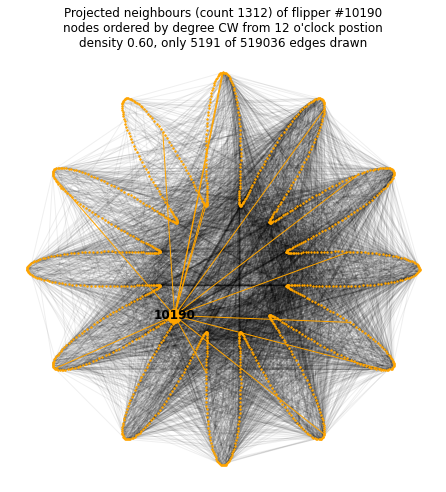

In [23]:
flipper_and_nbrs = list(Gp.neighbors(flipper_id)) + [flipper_id]
fan_degree = dict(Gp.degree(flipper_and_nbrs))
fan_degree_sorted = dict(sorted(fan_degree.items(), key=lambda item: item[1], reverse=True))
Gpf = Gp.subgraph(flipper_and_nbrs)

draw_edge_list = list(Gpf.edges())[::100]

plt.figure(figsize=(6, 6))
pospf = circ_rank_pos(fan_degree_sorted.keys())
nx.draw(Gpf,
        pos=pospf,
        edgelist=draw_edge_list,
        edge_color='#00000010',
        node_color='orange',
        node_size=2)
nx.draw(Gpf,
        pos=pospf,
        nodelist=[flipper_id],
        edgelist=list(Gpf.edges(flipper_id))[::100],
        edge_color='orange',
        node_color='orange',
        node_size=200)
nx.draw_networkx_labels(Gpf,
                        pos=pospf,
                        labels={n:n for n in [flipper_id]},
                        font_weight='bold')
plt.title(f'Projected neighbours (count {Gp.degree(flipper_id)}) of flipper #{flipper_id}\n'
          + "nodes ordered by degree CW from 12 o'clock postion\n"
          + f'density {nx.density(Gpf):.2f}, only {len(draw_edge_list)} of {len(Gpf.edges())} edges drawn')
plt.show()

In [24]:
slope_id = '3039'
plate_id = '3023'

flipper_degree = nx.degree(Gp, flipper_id)
slope_degree = nx.degree(Gp, slope_id)
plate_degree = nx.degree(Gp, plate_id)

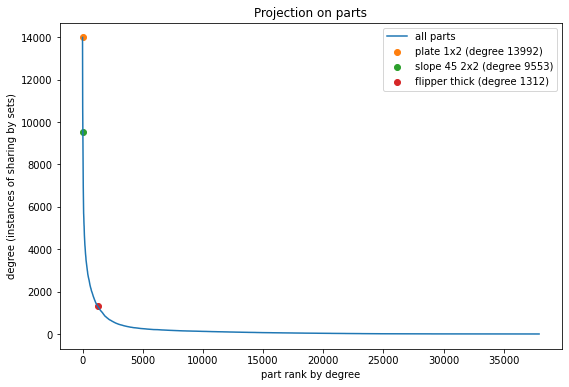

In [25]:
part_degree_sorted = sorted([d for n, d in Gp.degree()], reverse=True)
plt.figure(figsize=(9, 6))
plt.plot(range(len(part_degree_sorted)), part_degree_sorted)
plt.scatter(part_degree_sorted.index(plate_degree), plate_degree, color='tab:orange')
plt.scatter(part_degree_sorted.index(slope_degree), slope_degree, color='tab:green')
plt.scatter(part_degree_sorted.index(flipper_degree), flipper_degree, color='tab:red')
plt.legend(['all parts',
            f'plate 1x2 (degree {plate_degree})',
            f'slope 45 2x2 (degree {slope_degree})',
            f'flipper thick (degree {flipper_degree})'])
plt.ylabel('degree (instances of sharing by sets)')
plt.xlabel('part rank by degree')
plt.title('Projection on parts')
plt.show()

In [26]:
def part_connections(part_num, part_cx_list, axes, title):
  sel_pcx = part_cx_list + [part_num]
  Spcx = Gp.subgraph(sel_pcx)
  pos_pcx = nx.circular_layout(Spcx)
  dns_pcx = nx.density(Spcx)
  nx.draw(Spcx,
          pos=pos_pcx,
          nodelist=part_cx_list,
          ax=axes,
          with_labels=True,
          node_color='lightgrey',
          edge_color='lightgrey')
  nx.draw(Spcx,
          pos=pos_pcx,
          nodelist=[part_num],
          edgelist=Spcx.edges(part_num),
          ax=axes,
          with_labels=True,
          node_color='orange',
          edge_color='orange')
  axes.set_title(f'{title}, density {dns_pcx:.2f}')

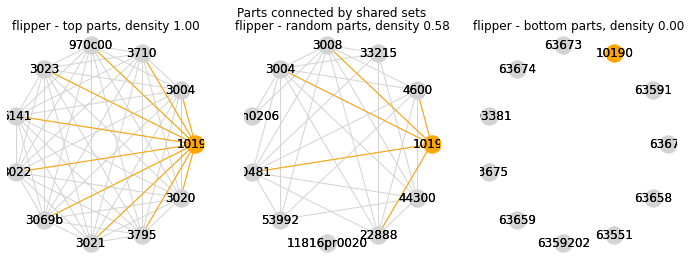

In [27]:
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(4)

part_connections(flipper_id, list(ps_inc_sort.index)[:10], ax[0], 'flipper - top parts')
part_connections(flipper_id, edge_sample(1, 10), ax[1], 'flipper - random parts')
part_connections(flipper_id, list(ps_inc_sort.index)[-10:], ax[2], 'flipper - bottom parts')

fig.suptitle('Parts connected by shared sets')
plt.show()

In [28]:
def path_exists_all(part_num):
  return [p for p in spq_parts if nx.has_path(Gp, part_num, p)]

def path_length_all(part_num):
  exists = path_exists_all(part_num)
  return {p: nx.shortest_path_length(Gp, part_num, p) for p in exists}

def parts_by_path_length(path_length):
  pbpl = {l: [] for l in set(path_length.values())}
  for p, l in path_length.items():
    pbpl[l].append(p)
  return pbpl

In [29]:
path_length_flipper = path_length_all(flipper_id)

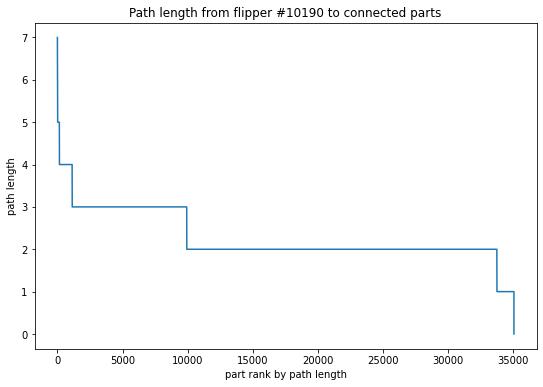

In [30]:
plt.figure(figsize=(9, 6))
plt.plot(sorted(path_length_flipper.values(), reverse=True))
plt.title(f'Path length from flipper #{flipper_id} to connected parts')
plt.ylabel('path length')
plt.xlabel('part rank by path length')
plt.show()

In [31]:
flipper_pbpl = parts_by_path_length(path_length_flipper)
furthest_part = random.choice(flipper_pbpl[7])
furthest_path = nx.shortest_path(Gp, flipper_id, furthest_part)
furthest_path_branches = list(flatten([list(Gp.neighbors(n))[:2] for n in furthest_path]))

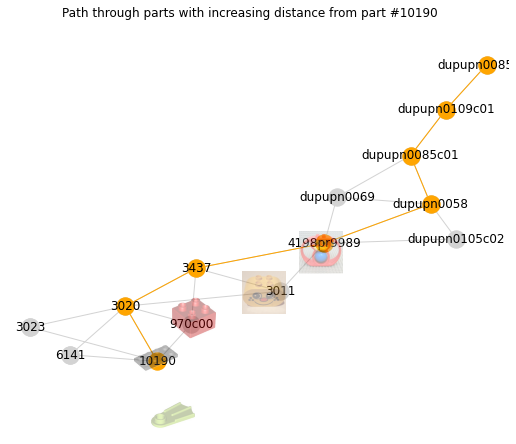

In [32]:
Spp = Gp.subgraph(furthest_path + furthest_path_branches)

fig, ax = plt.subplots()
fig.set_figwidth(9)
fig.set_figheight(6)

random.seed()
pos_pp = nx.kamada_kawai_layout(Spp)
nx.draw(Spp,
        pos=pos_pp,
        nodelist=furthest_path_branches,
        edgelist=Spp.edges(furthest_path),
        node_color='lightgrey',
        edge_color='lightgrey')
nx.draw(Spp,
        pos=pos_pp,
        nodelist=furthest_path,
        edgelist=[e for e in Spp.edges(furthest_path) if e[0] in furthest_path and e[1] in furthest_path],
        with_labels=True,
        node_color='orange',
        edge_color='orange')
inset_d = 0.1
for pn in furthest_path:
  inset_x = (pos_pp[pn][0] + 1) / 2.3
  inset_y = (pos_pp[pn][1] + 0.6) / 2.3
  inset = fig.add_axes([inset_x, inset_y, inset_d, inset_d])
  inset.imshow(transparent_part_image(pn, content_alpha=96), cmap='Greys')
  inset.axis('off')
fig.suptitle(f'Path through parts with increasing distance from part #{flipper_id}')
plt.show()

# Set Projections

In [33]:
sns = [10, 20, 50, 100, 200, 500, 1000, 2000]

In [34]:
Gs = None
ssp = []
dss = []
rnk = []

for i, sn in enumerate(sns):
  ssp.append(edge_sample(0, sn))
  Gs = bipartite.projected_graph(B, ssp[-1])
  dss.append(sorted([d for n, d in Gs.degree()], reverse=True))
  nproj = len(dss[-1])
  rnk.append(np.linspace(0, len(spq_sets), nproj))

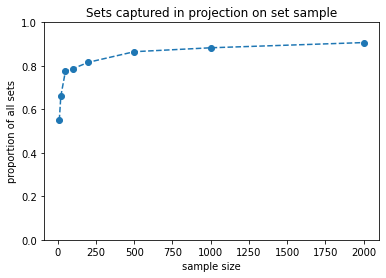

In [35]:
plt.plot(sns, [len(d) / len(spq_sets) for d in dss], 'o--')
plt.ylim((0, 1))
plt.title('Sets captured in projection on set sample')
plt.xlabel('sample size')
plt.ylabel('proportion of all sets')
plt.show()

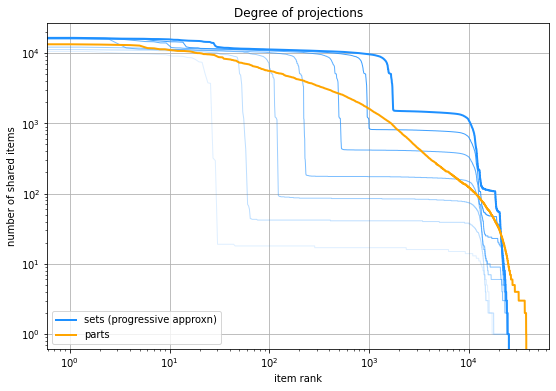

In [36]:
plt.figure(figsize=(9, 6))

for i, sn in enumerate(sns):
  plt.plot(rnk[i],
           dss[i],
           color='dodgerblue',
           alpha=(i / (len(sns) - 1)),
           label=(None if i < (len(sns) - 1) else 'sets (progressive approxn)'),
           lw=(1 if i < (len(sns) - 1) else 2))

plt.plot(range(len(part_degree_sorted)),
         part_degree_sorted, color='orange',
         label='parts',
         lw=2)

plt.yscale('log')
plt.xscale('log')
plt.title('Degree of projections')
plt.legend()
plt.ylabel('number of shared items')
plt.xlabel('item rank')
plt.grid()
plt.show()

In [37]:
coast_guard_id = '60012-1'
nx.degree(Gs, coast_guard_id)

1427

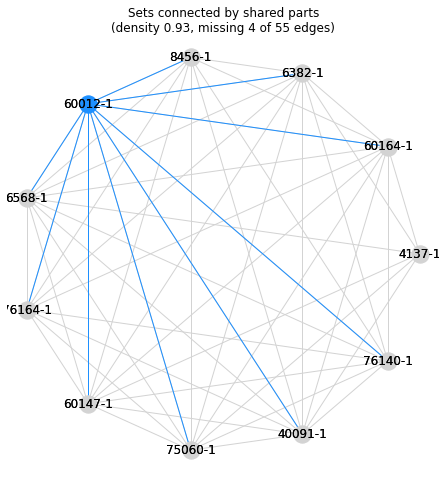

In [38]:
rnd_cx = random.sample(ssp[-1], 10)
sel_cx = rnd_cx + [coast_guard_id]
Ss = Gs.subgraph(sel_cx)
pos_s = nx.circular_layout(Ss)
ds = nx.density(Ss)

fig = plt.figure(figsize=(6, 6))
nx.draw(Ss,
        pos=pos_s,
        nodelist=rnd_cx,
        with_labels=True,
        node_color='lightgrey',
        edge_color='lightgrey')
nx.draw(Ss,
        pos=pos_s,
        nodelist=[coast_guard_id],
        edgelist=Ss.edges(coast_guard_id),
        with_labels=True,
        node_color='dodgerblue',
        edge_color='dodgerblue')
plt.title(f'Sets connected by shared parts\n(density {ds:.2f}, missing {55 - len(Ss.edges)} of 55 edges)')
plt.show()

# Comparing Sampling Techniques

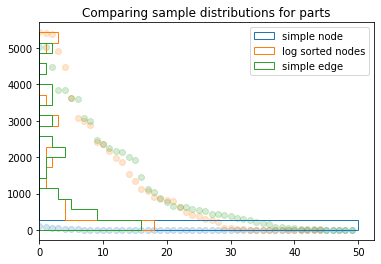

In [39]:
tgt_smpl = 50

part_sample_pop = node_sample_pop(spq_parts, tgt_smpl)
part_sample_log = node_sample_log(spq_parts, tgt_smpl)
part_sample_edge = edge_sample(1, tgt_smpl)

plt.scatter(range(len(part_sample_pop)), ps_inc_sort.loc[part_sample_pop].sort_values(ascending=False), alpha=0.2)
plt.scatter(range(len(part_sample_log)), ps_inc_sort.loc[part_sample_log], alpha=0.2)
plt.scatter(range(len(part_sample_edge)), ps_inc_sort.loc[part_sample_edge].sort_values(ascending=False), alpha=0.2)

common_bins_parts = np.linspace(1, max(ps_inc_sort.loc[part_sample_log]), num=20)
plt.hist(ps_inc_sort.loc[part_sample_pop], orientation='horizontal', bins=common_bins_parts, histtype='step')
plt.hist(ps_inc_sort.loc[part_sample_log], orientation='horizontal', bins=common_bins_parts, histtype='step')
plt.hist(ps_inc_sort.loc[part_sample_edge], orientation='horizontal', bins=common_bins_parts, histtype='step')
plt.title('Comparing sample distributions for parts')
plt.legend(['simple node', 'log sorted nodes', 'simple edge'])
plt.show()

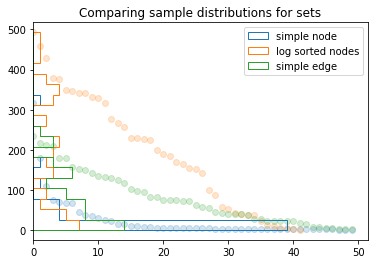

In [41]:
set_sample_pop = node_sample_pop(spq_sets, tgt_smpl)
set_sample_log = node_sample_log(spq_sets, tgt_smpl)
set_sample_edge = edge_sample(0, tgt_smpl)

plt.scatter(range(len(set_sample_pop)), sp_inc_sort.loc[set_sample_pop].sort_values(ascending=False), alpha=0.2)
plt.scatter(range(len(set_sample_log)), sp_inc_sort.loc[set_sample_log], alpha=0.2)
plt.scatter(range(len(set_sample_edge)), sp_inc_sort.loc[set_sample_edge].sort_values(ascending=False), alpha=0.2)

common_bins_sets = np.linspace(1, max(sp_inc_sort.loc[set_sample_log]), num=20)
plt.hist(sp_inc_sort.loc[set_sample_pop], orientation='horizontal', bins=common_bins_sets, histtype='step')
plt.hist(sp_inc_sort.loc[set_sample_log], orientation='horizontal', bins=common_bins_sets, histtype='step')
plt.hist(sp_inc_sort.loc[set_sample_edge], orientation='horizontal', bins=common_bins_sets, histtype='step')
plt.title('Comparing sample distributions for sets')
plt.legend(['simple node', 'log sorted nodes', 'simple edge'])
plt.show()

# Graph Properties Overall

In [42]:
def safe_redundancy(sample_nodes):
  sample_nodes_nbrs = [p for p in sample_nodes if nx.degree(B, p) > 1]
  sample_no_nbrs = set(sample_nodes) - set(sample_nodes_nbrs)
  redundancy_no_nbrs = {p: 0 for p in sample_no_nbrs}
  return dict(bipartite.node_redundancy(B, sample_nodes_nbrs), **redundancy_no_nbrs)
  
part_redundancy = safe_redundancy(part_sample_pop)
set_redundancy = safe_redundancy(set_sample_pop)

part_clustering = bipartite.clustering(B, part_sample_pop)
set_clustering = bipartite.clustering(B, set_sample_pop)

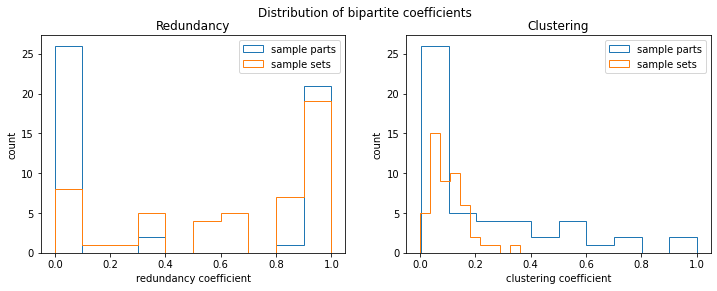

In [43]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)

ax[0].hist(part_redundancy.values(), histtype='step')
ax[0].hist(set_redundancy.values(), histtype='step')
ax[0].legend(['sample parts', 'sample sets'])
ax[0].set_title('Redundancy')
ax[0].set_xlabel('redundancy coefficient')
ax[0].set_ylabel('count')

ax[1].hist(part_clustering.values(), histtype='step')
ax[1].hist(set_clustering.values(), histtype='step')
ax[1].legend(['sample parts', 'sample sets'])
ax[1].set_title('Clustering')
ax[1].set_xlabel('clustering coefficient')
ax[1].set_ylabel('count')

fig.suptitle('Distribution of bipartite coefficients')
plt.show()